In [1]:
import math
import numpy as np
from disturbances import IntegratedWhiteNoise
import os
from constants import *
from diff_calc import get_mass_matrix
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [17]:
J = np.array([[1, 0, -(d_bf-(L_bc/2))],
              [0, -1, -d_ae],
              [1, 0, -d_bf], 
              [0, -1, (d_ad-d_ae)],
              [1, 0, (L_bc - d_bf)],
              [0, -1, (d_ad - d_ae)]])

f_a = 100
phi_a = 0

f_b = 0
phi_b = 0

f_c = 0
phi_c = 0

f = np.array([f_a*np.sin(phi_a), f_a*np.cos(phi_a), 
              f_b*np.sin(phi_b), f_b*np.cos(phi_b), 
              f_c*np.sin(phi_c), f_c*np.cos(phi_c)])


In [4]:
def get_thrust_7a(input_vec):
    J = np.array([[1, 0, -(d_bf - (L_bc / 2))],
                  [0, -1, -d_ae],
                  [1, 0, -d_bf],
                  [0, -1, (d_ad - d_ae)],
                  [1, 0, (L_bc - d_bf)],
                  [0, -1, (d_ad - d_ae)]])
    J = J.T

    J_plus = J.T @ np.linalg.inv(J @ J.T)
    return J_plus @ input_vec

In [5]:
get_thrust_7a(np.array([0, 100, 100]))

array([  0.        , -49.05193424,  -9.95260664, -25.47403288,
         9.95260664, -25.47403288])

In [15]:
f_x = 300
f_y = 0
n = 0

dv = (L_ac + L_bc)/2
J_star = np.array([[1, 0, -(d_bf-(L_bc/2))/dv],
                   [0, -1, -d_ae/dv],
                   [1, 0, -d_bf/dv],
                   [0, -1, (d_ad-d_ae)/dv],
                   [1, 0, (L_bc - d_bf)/dv],
                   [0, -1, (d_ad - d_ae)/dv]])

J_star_plus = J_star @ np.linalg.inv(J_star.T @ J_star)

q_star = np.array([f_x, f_y, n])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 6 is different from 3)

In [34]:
def get_thrust_msgs(input_vec):
    dv = (L_ac + L_bc) / 2
    J_star = np.array([[1, 0, -(d_bf - (L_bc / 2)) / dv],
                       [0, -1, -d_ae / dv],
                       [1, 0, -d_bf / dv],
                       [0, -1, (d_ad - d_ae) / dv],
                       [1, 0, (L_bc - d_bf) / dv],
                       [0, -1, (d_ad - d_ae) / dv]])
    J_star = J_star.T

    J_star_plus = J_star.T @ np.linalg.inv(J_star @ J_star.T)
    # q_star = np.array([input_vec[0], input_vec[1], input_vec[2]/dv])
    q_star = input_vec
    return J_star_plus @ q_star

In [35]:
get_thrust_msgs(np.array([100, 0, 100]))

array([ 33.33333333, -62.87440361,  -6.47709321,  31.4372018 ,
        73.14375987,  31.4372018 ])

In [27]:
n = np.empty((3, 0))
n = np.column_stack((n, np.array([1, 2, 3])))
np.column_stack((n, np.array([1, 2, 3])))

array([[1., 1.],
       [2., 2.],
       [3., 3.]])

In [19]:
# Reading from a MCAP file
from mcap_ros2.reader import read_ros2_messages

pos = np.empty((3, 0))
vel = np.empty((3, 0))
acc = np.empty((3, 0))

for msg in read_ros2_messages("../bagfiles/record8/record8_0.mcap"):
    if msg.channel.topic == "/model/vereniki/odometry":
        # print(f"{msg.ros_msg.pose.pose.position.x}: \n")
        pos = np.column_stack((pos, np.array([msg.ros_msg.pose.pose.position.x,
                                              msg.ros_msg.pose.pose.position.y,
                                              msg.ros_msg.pose.pose.orientation.z])))
        vel = np.column_stack((vel, np.array([msg.ros_msg.twist.twist.linear.x,
                                              msg.ros_msg.twist.twist.linear.y,
                                              msg.ros_msg.twist.twist.angular.z])))
    if msg.channel.topic == "/model/vereniki/imu":
        # print(f"{msg.ros_msg.linear_acceleration.x}")
        acc = np.column_stack((acc, np.array([msg.ros_msg.linear_acceleration.x,
                                              msg.ros_msg.linear_acceleration.y,
                                              0])))

    
odom_data = {'Position-x': pos[0, :], 
        'Position-y': pos[1, :], 
        'Orientation-z': pos[2, :],
        'Velocity-x': vel[0, :],
        'Velocity-y': vel[1, :],
        'Velocity-z': vel[2, :]}

imu_data= {'Acceleration-x': acc[0, :],
           'Acceleration-y': acc[1, :],
           'Acceleration-z': acc[2, :]}
odom_sim_data = pd.DataFrame(odom_data)
imu_sim_data = pd.DataFrame(imu_data)
odom_data_size = odom_sim_data.shape[0]
imu_data_size = imu_sim_data.shape[0]

In [20]:
def align_values(data, size):
    selected_indices = np.linspace(0, len(data) - 1, size, dtype=int)
    return data.iloc[selected_indices].reset_index(drop=True)

In [44]:
diff_data = pd.read_csv('output.csv')
diff_data

,Position-x,Position-y,Orientation-z,Velocity-x,Velocity-y,Velocity-z,Acceleration-x,Acceleration-y,Acceleration-z
0,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000,0.000000e+00,0.000000,0.001307,0.000000e+00,0.000041,1.307190e-01,0.000000e+00,4.078554e-03
2,0.000013,0.000000e+00,0.000023,0.002033,-6.055090e-13,0.000048,7.262088e-02,-6.055090e-11,7.635888e-04
3,0.000033,8.287270e-12,0.000051,0.003018,-9.886644e-13,0.000083,9.844117e-02,-3.831554e-11,3.457828e-03
4,0.000064,3.519835e-11,0.000099,0.003887,-3.030430e-12,0.000096,8.696327e-02,-2.041766e-10,1.267878e-03
...,...,...,...,...,...,...,...,...,...
5995,29.373202,6.494289e+00,23.563007,0.542712,-2.902402e-06,0.006870,8.366451e-10,1.916038e-10,-2.032660e-10
5996,29.378177,6.496459e+00,23.566943,0.542712,-2.902400e-06,0.006870,8.338933e-10,1.912848e-10,-2.026357e-10
5997,29.383151,6.498629e+00,23.570879,0.542712,-2.902398e-06,0.006870,8.311506e-10,1.909664e-10,-2.020073e-10
5998,29.388126,6.500799e+00,23.574816,0.542712,-2.902396e-06,0.006870,8.284169e-10,1.906485e-10,-2.013809e-10


In [45]:
x_pos_diff = align_values(diff_data['Position-x'], odom_data_size)
y_pos_diff = align_values(diff_data['Position-y'], odom_data_size)
z_orient_diff = align_values(diff_data['Orientation-z'], odom_data_size)

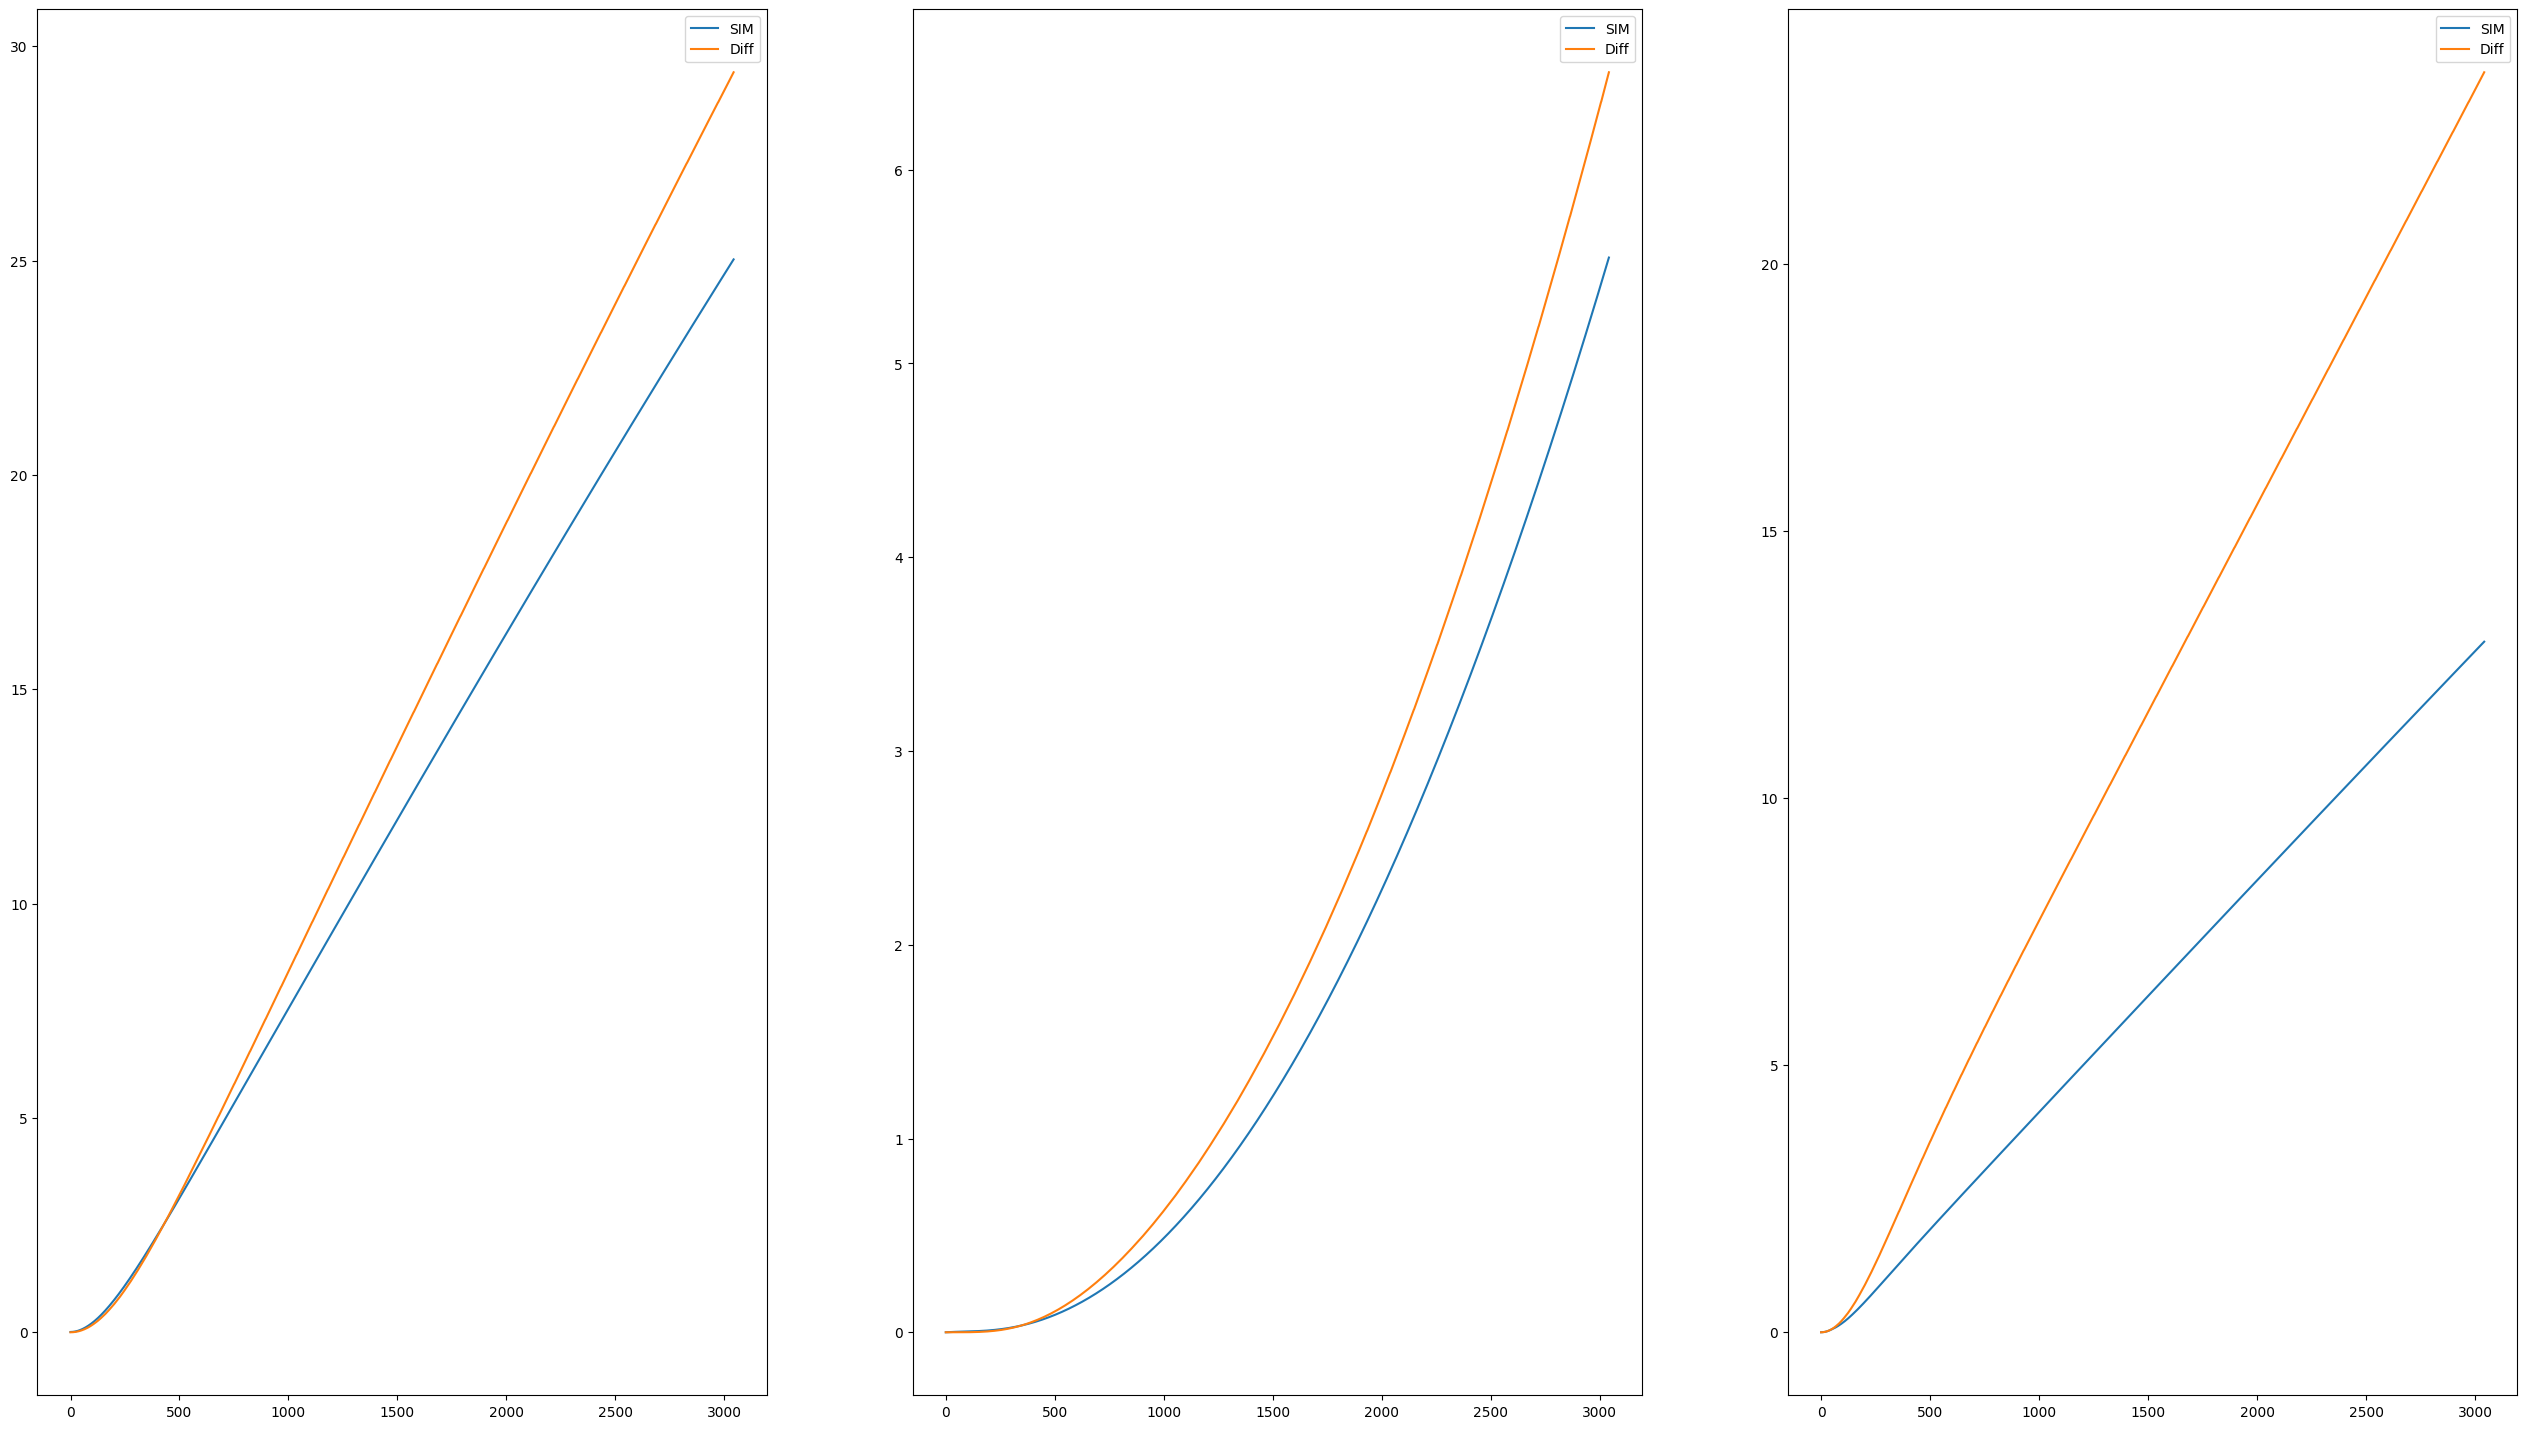

In [46]:
def radians_to_degrees(radians):
    degrees = np.degrees(radians)
    degrees = (degrees + 180) % 360 - 180
    return degrees

fig, ax = plt.subplots(1, 3, sharex=True, sharey=False)
fig.set_figwidth(32)
fig.set_figheight(18)
ax[0].plot(odom_data['Position-x'], label='SIM')
ax[0].plot(x_pos_diff, label='Diff')
ax[0].legend()

ax[1].plot(odom_data['Position-y'], label='SIM')
ax[1].plot(y_pos_diff, label='Diff')
ax[1].legend()

ax[2].plot(pd.DataFrame(odom_data['Orientation-z']).
           apply(radians_to_degrees), label='SIM')
ax[2].plot(z_orient_diff, label='Diff')
ax[2].legend()

plt.show()

In [39]:
z_orient_diff

0        0.000000
1        0.000000
2        0.000051
3        0.000153
4        0.000307
          ...    
3038    23.547261
3039    23.555134
3040    23.563007
3041    23.570879
3042     0.411527
Name: Orientation-z, Length: 3043, dtype: float64